## Preliminaries

In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 500 µs (started: 2023-08-30 10:54:57 +08:00)


In [2]:
# check python version
# lensinggw package requires python 3.8+

! python --version

Python 3.9.13
time: 124 ms (started: 2023-08-30 10:54:57 +08:00)


In [3]:
# cd to lenstronomy location
%cd /Users/genebelinario/Documents/dnc_research/thesis/notebooks
!ls

/Users/genebelinario/Documents/dnc_research/thesis/notebooks
LOSC_Event_tutorial-master lenstronomy_solver.ipynb
PML_Lensing.ipynb          near_source.ipynb
gw_microlensing.ipynb      plot_10e610e7.ipynb
gwlensing_10e7.ipynb       plots.ipynb
lensed_gw.ipynb            source_0.png
lensed_unlensed_gw.ipynb   source_1.png
lensinggw                  source_2.png
lensinggw_setup.ipynb      try.ipynb
lenstronomy
time: 129 ms (started: 2023-08-30 10:54:57 +08:00)


In [4]:
# import libraries and packages

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import configparser
import pandas as pd

time: 693 ms (started: 2023-08-30 10:54:58 +08:00)


In [5]:
# import specific packages
from lensinggw.utils.utils import param_processing
from lensinggw.solver.images import microimages
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
from lensinggw.postprocess.postprocess import plot_images

time: 794 ms (started: 2023-08-30 10:54:59 +08:00)


## **Unlensed Gravitational Wave Signal**

In [11]:
# This script illustrates how to use lensingGW's unlensed waveform routines

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the unlensed waveform polarizations, strains in the requested detectors and their frequencies
freqs, hp_tilde, hc_tilde, strain_dict = waveform_model.unlensed_gw()

# and their signal-to-noise-ratios
SNR_dict = waveform_model.unlensed_snr()

# access an unlensed strain
sH1 = strain_dict['H1']


---- Will simulate a signal with the following parameters ----

m1          --> 45
m2          --> 36
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 0
dec         --> 4.904407255147181e-09
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Unlensed SNR in H1 = 1.80
Network SNR of the unlensed simulation 1.804045

time: 93

[-1.65795546e-28-6.78218177e-29j -1.65727490e-28-6.77182411e-29j
 -1.65656488e-28-6.76137900e-29j ... -1.66005132e-28-6.81359837e-29j
 -1.65934463e-28-6.80302602e-29j -1.65866342e-28-6.79267103e-29j]


/Users/genebelinario/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


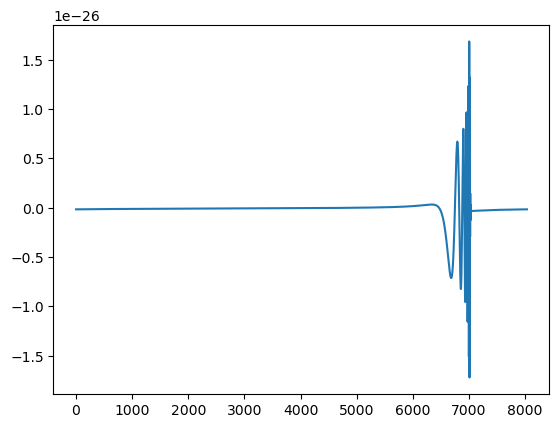

time: 88.8 ms (started: 2023-08-30 14:58:51 +08:00)


In [10]:
print(np.fft.ifft(sH1))

plt.plot(np.fft.ifft(sH1))

## **Case 1**

For an SIE with mass $M_G = 10^{6}M_{\odot}$. 

In [12]:
## Determine macroimages of the SIE.

# coordinates in scaled units x (radians) / thetaE
# a.k.a source position in scaled units
y0, y1 = 0, 0.5

# redshifts
zS = 2.0
zL = 0.5

# mass of lens in solar mass units
mSIE_10e6 = 10**6

# Einstein angle in radians
thetaE_SIE_10e6 = param_processing(zL, zS, mSIE_10e6)

# source position in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# lens model
lens_model_list     = ['SIE']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_lens_list    = [kwargs_SIE]

# compute for macroimage positions
solver_kwargs = {'SearchWindowMacro' : 4*thetaE_SIE_10e6,
                         'OnlyMacro' : True,
                        'MacroIndex' : [0],
                      'Optimization' : True,
                       'PixelsMacro' : 10**3} 

MacroImg_ra_10e6, MacroImg_dec_10e6, pixel_width_10e6  = microimages(source_pos_x    = beta0,
                                                                     source_pos_y    = beta1,
                                                                     lens_model_list = lens_model_list,
                                                                     kwargs_lens     = kwargs_lens_list,
                                                                     **solver_kwargs)

# time delays
tds_10e6 = TimeDelay(MacroImg_ra_10e6, MacroImg_dec_10e6, beta0, beta1, zL, zS,
                     lens_model_list, kwargs_lens_list) 

# magnifications
mus_10e6 = magnifications(MacroImg_ra_10e6, MacroImg_dec_10e6, lens_model_list, kwargs_lens_list)

# Morse indices
ns_10e6  = getMinMaxSaddle(MacroImg_ra_10e6, MacroImg_dec_10e6, lens_model_list, kwargs_lens_list) 
                
print('Time delays (seconds): ', tds_10e6)
print('magnifications: ',  mus_10e6)
print('Morse indices: ',ns_10e6)

dummy_frequencies = np.linspace(0,10,11)
F = geometricalOpticsMagnification(dummy_frequencies,
                                   MacroImg_ra_10e6, MacroImg_dec_10e6,
                                   beta0,beta1,
                                   zL,zS,
                                   lens_model_list,
                                   kwargs_lens_list)
print('Geometrical optics amplification factor:', F)


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> True
Scaled                          --> False
SearchWindowMacro               --> 3.923525804117745e-08
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-15
NearSource                      --> False
Optimization                    --> True
Verbose                         --> False
OptimizationWindowMacro         --> 2
OptimizationPixelsMacro         --> 30
MinDistMacro                    --> None
ImprovementMacro                --> None
OptimizationPrecisionLimitMacro --> 1e-20




MACROIMAGES

ra: [ 7.64953018e-21 -4.96308526e-24 -4.96308526e-24]
dec: [ 1.43606231e-08 -4.39823477e-09 -1.56357004e-10]

Time delays (seconds):  [ 0.         28.34730176 30.476578  ]
magnifications:  [ 3.80591423e+00 -7.70297588e-01  1.19870864e-03]
Morse indices:  [0, 0.5, 1]
Geometrical o

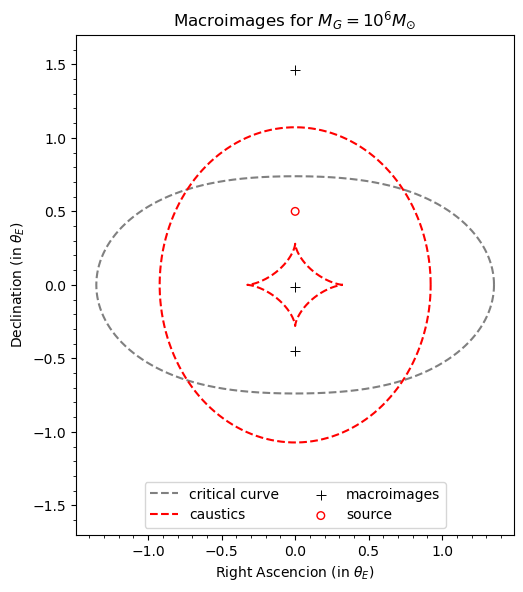

time: 521 ms (started: 2023-06-19 19:13:10 +08:00)


In [13]:
## parametrized curves

epsilon = 0.15
t = np.arange(0, 2*np.pi, 0.001)

# inner caustics
beta_1_in = (2*epsilon/np.sqrt(1-epsilon))*((np.cos(t))**3)
beta_2_in = (2*epsilon/np.sqrt(1+epsilon))*((np.sin(t))**3)

# outer caustics
beta_1_out = ((1-epsilon)/np.sqrt(1-epsilon))*np.cos(t)
beta_2_out = ((1+epsilon)/np.sqrt(1+epsilon))*np.sin(t)

# critical curve
rho = 1 + epsilon*np.cos(2*t)
theta_1 = (1-epsilon)**(-1)*rho*np.cos(t)
theta_2 = (1+epsilon)**(-1)*rho*np.sin(t)

# Sky plot of the macroimages
nr_10e6, nc_10e6 = 1, 1

fig_10e6, axs_10e6 = plt.subplots(nrows=nr_10e6, ncols=nc_10e6, sharey=True, sharex=True, figsize=(6,6))
axs_10e6.plot(theta_1, theta_2, color='grey', linewidth=1.5, label='critical curve', linestyle='--')
axs_10e6.plot(beta_1_in, beta_2_in, color='red', linewidth=1.5, label='caustics', linestyle='--')
axs_10e6.plot(beta_1_out, beta_2_out, color='red', linewidth=1.5, linestyle='--')
axs_10e6.scatter(MacroImg_ra_10e6/thetaE_SIE_10e6, MacroImg_dec_10e6/thetaE_SIE_10e6, marker='+', label='macroimages', 
                 s=60, linewidth=0.7, color='black')
axs_10e6.scatter(y0, y1, color='red', s=30, label='source', facecolor='none')

axs_10e6.set_title(r'Macroimages for $M_G = 10^{6}M_{\odot}$')
axs_10e6.set(xlabel=r'Right Ascencion (in $\theta_E$)', ylabel=r'Declination (in $\theta_E$)')
axs_10e6.label_outer()
axs_10e6.minorticks_on()
#axs_10e6.set_xlim([-1.7,1.7])
axs_10e6.set_ylim([-1.7,1.7])
axs_10e6.set_aspect('equal', adjustable='box')
axs_10e6.legend(ncol=2, loc='lower center')

#axs_10e6.text(0.1, 1.3, r'$\mu = 3.806$' + '\n' + r'$t_d = 0$' + '\n' + r'$n=0$')
#axs_10e6.text(0.1, 0.05, r'$\mu = 0.001$' + '\n' + r'$t_d = 30.477$' + '\n' + r'$n=1$')
#axs_10e6.text(0.1, -0.63, r'$\mu = -0.771$' + '\n' + r'$t_d = 28.347$' + '\n' + r'$n=0.5$')

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/MacroImg_10e6', dpi=300)
plt.show()

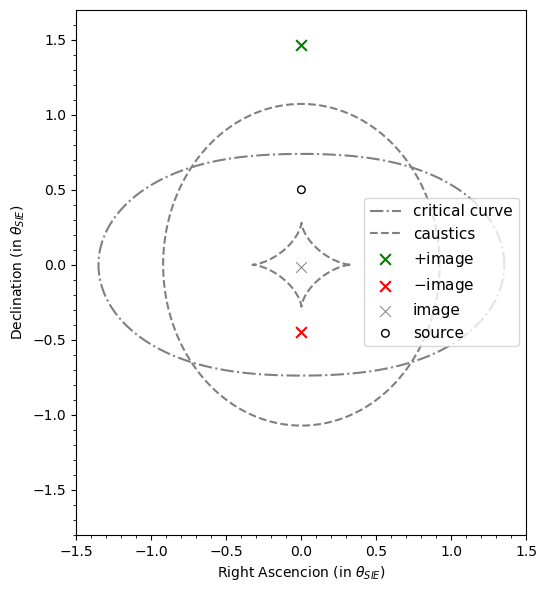

time: 314 ms (started: 2023-06-19 19:13:11 +08:00)


In [14]:
## parametrized curves

epsilon = 0.15
t = np.arange(0, 2*np.pi, 0.001)

# inner caustics
beta_1_in = (2*epsilon/np.sqrt(1-epsilon))*((np.cos(t))**3)
beta_2_in = (2*epsilon/np.sqrt(1+epsilon))*((np.sin(t))**3)

# outer caustics
beta_1_out = ((1-epsilon)/np.sqrt(1-epsilon))*np.cos(t)
beta_2_out = ((1+epsilon)/np.sqrt(1+epsilon))*np.sin(t)

# critical curve
rho = 1 + epsilon*np.cos(2*t)
theta_1 = (1-epsilon)**(-1)*rho*np.cos(t)
theta_2 = (1+epsilon)**(-1)*rho*np.sin(t)

# Sky plot of the macroimages
nr_10e6, nc_10e6 = 1, 1

fig_10e6, axs_10e6 = plt.subplots(nrows=nr_10e6, ncols=nc_10e6, sharey=True, sharex=True, figsize=(6,6))
axs_10e6.plot(theta_1, theta_2, color='grey', linewidth=1.5, label='critical curve', linestyle='-.')
axs_10e6.plot(beta_1_in, beta_2_in, color='grey', linewidth=1.5, label='caustics', linestyle='--')
axs_10e6.plot(beta_1_out, beta_2_out, color='grey', linewidth=1.5, linestyle='--')
axs_10e6.scatter(MacroImg_ra_10e6[0]/thetaE_SIE_10e6, MacroImg_dec_10e6[0]/thetaE_SIE_10e6, marker='x', label=r'$+$image', 
                 s=60, linewidth=1.5, color='green')
axs_10e6.scatter(MacroImg_ra_10e6[1]/thetaE_SIE_10e6, MacroImg_dec_10e6[1]/thetaE_SIE_10e6, marker='x', label=r'$-$image', 
                 s=60, linewidth=1.5, color='red')
axs_10e6.scatter(MacroImg_ra_10e6[2]/thetaE_SIE_10e6, MacroImg_dec_10e6[2]/thetaE_SIE_10e6, marker='x', label='image', 
                 s=60, linewidth=0.7, color='gray')
axs_10e6.scatter(y0, y1, color='black', s=30, label='source', facecolor='none')

#axs_10e6.set_title(r'Macroimages for $M_G = 10^{6}M_{\odot}$')
axs_10e6.set(xlabel=r'Right Ascencion (in $\theta_{SIE})$', ylabel=r'Declination (in $\theta_{SIE}$)')
axs_10e6.label_outer()
axs_10e6.minorticks_on()
axs_10e6.set_xlim([-1.5, 1.5])
axs_10e6.set_ylim([-1.8,1.7])
axs_10e6.set_aspect('equal', adjustable='box')
axs_10e6.legend(ncol=1, loc='right', fontsize=11)

#axs_10e6.text(0.1, 1.3, r'$\mu = 3.806$' + '\n' + r'$t_d = 0$' + '\n' + r'$n=0$')
#axs_10e6.text(0.1, 0.05, r'$\mu = 0.001$' + '\n' + r'$t_d = 30.477$' + '\n' + r'$n=1$')
#axs_10e6.text(0.1, -0.63, r'$\mu = -0.771$' + '\n' + r'$t_d = 28.347$' + '\n' + r'$n=0.5$')

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/MacroImg_10e6_spp2023', dpi=300)
plt.show()

In [15]:
# PML at most magnified image in the positive parity side of SIE

# Macroimages in the positive parity side
# RA, Dec = 7.64953018e-21, 1.43606231e-08 ; n = 0 ; mu = 3.80591423e+00 --> most magnified
# RA, Dec = -4.96308526e-24, -1.56357004e-10 ; n = 1 ; mu = 1.19870864e-03


# coordinates in scaled units x (radians) / thetaE
# a.k.a source position in scaled units
y0, y1 = 0, 0.5

# redshifts
zS = 2.0
zL = 0.5

# mass of lens in solar mass units
mSIE_10e6 = 10**6
mPML = 100
m_total = mSIE_10e6 + mPML

# Einstein angle in radians
thetaE_SIE_10e6 = param_processing(zL, zS, mSIE_10e6)
thetaE_PML = param_processing(zL, zS, mPML)
thetaE = param_processing(zL, zS, m_total)

print('theta_SIE ' + str(thetaE_SIE_10e6))

# source position in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[0], 'center_y':MacroImg_dec_10e6[0], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# compute for macroimage positions
solver_kwargs = {'SearchWindowMacro' : 4*thetaE_SIE_10e6,
                      'SearchWindow' : 4*thetaE_SIE_10e6,
                  'MacroIndex'       : [0],
                      'Optimization' : True,
                       'PixelsMacro' : 10**3} 

Img_ra_10e6_PML, Img_dec_10e6_PML, MacroImg_ra_10e6, MacroImg_dec_10e6, pixel_width_10e6  = microimages(source_pos_x= beta0,
                                                   source_pos_y    = beta1,
                                                   lens_model_list = lens_model_list,
                                                   kwargs_lens     = kwargs_lens_list,
                                                    **solver_kwargs)

# time delays
tds_10e6_PML = TimeDelay(Img_ra_10e6_PML, Img_dec_10e6_PML, beta0, beta1, zL, zS,
                     lens_model_list, kwargs_lens_list) 

# magnifications
mus_10e6_PML = magnifications(Img_ra_10e6_PML, Img_dec_10e6_PML, lens_model_list, kwargs_lens_list)

# Morse indices
ns_10e6_PML  = getMinMaxSaddle(Img_ra_10e6_PML, Img_dec_10e6_PML, lens_model_list, kwargs_lens_list) 
                
print('Time delays (seconds): ', tds_10e6_PML)
print('magnifications: ',  mus_10e6_PML)
print('Morse indices: ',ns_10e6_PML)

dummy_frequencies = np.linspace(0,10,11)
F = geometricalOpticsMagnification(dummy_frequencies,
                                   Img_ra_10e6_PML, Img_dec_10e6_PML,
                                   beta0,beta1,
                                   zL,zS,
                                   lens_model_list,
                                   kwargs_lens_list)
print('Geometrical optics amplification factor:', F)


theta_SIE 9.808814510294363e-09

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> False
Scaled                          --> False
SearchWindowMacro               --> 3.923525804117745e-08
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-15
NearSource                      --> False
Optimization                    --> True
Verbose                         --> False
OptimizationWindowMacro         --> 2
OptimizationPixelsMacro         --> 30
MinDistMacro                    --> None
ImprovementMacro                --> None
OptimizationPrecisionLimitMacro --> 1e-20




MACROIMAGES

ra: [ 7.64953018e-21 -4.96308526e-24 -4.96308526e-24]
dec: [ 1.43606231e-08 -4.39823477e-09 -1.56357004e-10]


---- Solver settings ----

The complete model analysis will be performed with the following settings:

Scaled                          --> False
OnlyMacro                       --> False
Ma

In [16]:
# change back to Img_ra_10e6_PML for the original run

# spp_micro_pos_ra = Img_ra_10e6_PML/thetaE
spp_micro_pos_ra = np.array([1.55964777e-12, -1.94614067e-02, 1.94614067e-02, 1.09144987e-12])

# spp_micro_pos_dec = Img_dec_10e6_PML/thetaE
spp_micro_pos_dec = np.array([1.45395614, 1.46385032, 1.46385032, 1.47400288])

print(spp_micro_pos_ra, "\n" ,spp_micro_pos_dec)

[ 1.55964777e-12 -1.94614067e-02  1.94614067e-02  1.09144987e-12] 
 [1.45395614 1.46385032 1.46385032 1.47400288]
time: 392 µs (started: 2023-06-19 19:13:12 +08:00)


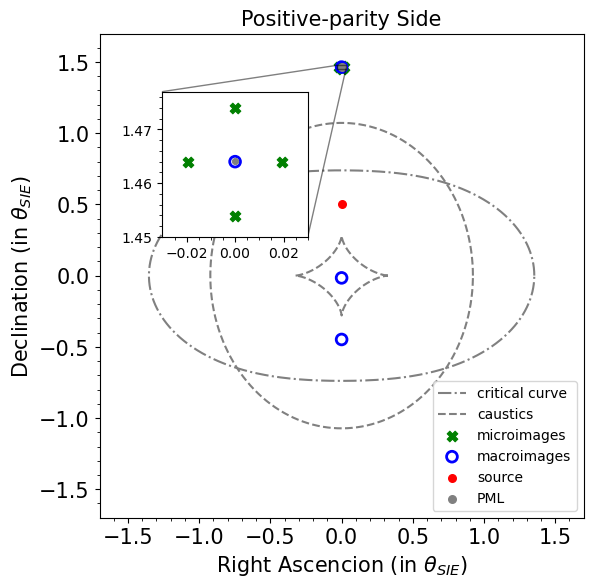

time: 509 ms (started: 2023-06-19 19:13:12 +08:00)


In [17]:
# Sky plot of the complete model
# PML at the most magnified macroimage on the positive side of the SIE

nr_10e6_PML, nc_10e6_PML = 1, 1

fig_10e6_PML, axs_10e6_PML = plt.subplots(nrows=nr_10e6_PML, ncols=nc_10e6_PML, sharey=True, sharex=True, figsize=(6,6))

axs_10e6_PML.plot(theta_1, theta_2, color='grey', linewidth=1.5, label='critical curve', linestyle='dashdot')
axs_10e6_PML.plot(beta_1_in, beta_2_in, color='grey', linewidth=1.5, label='caustics', linestyle='dashed')
axs_10e6_PML.plot(beta_1_out, beta_2_out, color='grey', linewidth=1.5, linestyle='dashed')

axs_10e6_PML.scatter(spp_micro_pos_ra, spp_micro_pos_dec, marker='X', label='microimages', 
                     s=60, linewidth=0.7, color='green')
axs_10e6_PML.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='o', label='macroimages', 
                     s=60, linewidth=2, color='blue', facecolor='none')
axs_10e6_PML.scatter(y0, y1, color='red', s=30, label='source')
axs_10e6_PML.scatter(MacroImg_ra_10e6[0]/thetaE_SIE_10e6, MacroImg_dec_10e6[0]/thetaE_SIE_10e6, 
                     label='PML', color='grey', s=30)

# inset axes....
axins_10e6_PML = axs_10e6_PML.inset_axes([0.13, 0.58, 0.3, 0.3])
axins_10e6_PML.scatter(spp_micro_pos_ra, spp_micro_pos_dec, marker='X', label='microimages', 
                 s=60, linewidth=0.7, color='green')
axins_10e6_PML.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='o', label='macroimages', 
                     s=60, linewidth=2, color='blue', facecolor='none')
axins_10e6_PML.scatter(MacroImg_ra_10e6[0]/thetaE_SIE_10e6, MacroImg_dec_10e6[0]/thetaE_SIE_10e6, 
                     label='PML', color='gray', s=20, linewidth=0.7)


# sub region of the original image
xx1, xx2, yy1, yy2 = -0.03, 0.03, 1.45, 1.477
axins_10e6_PML.set_xlim(xx1, xx2)
axins_10e6_PML.set_ylim(yy1, yy2)
#axins_10e6_PML.set_xticklabels([])
#axins_10e6_PML.set_yticklabels([])
axins_10e6_PML.minorticks_on()
axs_10e6_PML.indicate_inset_zoom(axins_10e6_PML, edgecolor="black")
axs_10e6_PML.minorticks_on()


axs_10e6_PML.set_title(r'Positive-parity Side')
axs_10e6_PML.title.set_size(15)
#axs_10e6_PML.set(xlabel=r'Right Ascencion (in $\theta_{SIE}$)', ylabel=r'Declination (in $\theta_{SIE}$)')
axs_10e6_PML.set_xlabel(r'Right Ascencion (in $\theta_{SIE}$)', fontsize=15)
axs_10e6_PML.set_ylabel(r'Declination (in $\theta_{SIE}$)', fontsize=15)
axs_10e6_PML.label_outer()
axs_10e6_PML.minorticks_on()
axs_10e6_PML.set_xlim([-1.7,1.7])
axs_10e6_PML.set_ylim([-1.7,1.7])
axs_10e6_PML.set_aspect('equal', adjustable='box')
axs_10e6_PML.legend(ncol=1, loc='lower right', )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/micro_pos_parity', dpi=300)
plt.show()

In [18]:
# PML at most magnified image in the negative parity side of SIE

# Macroimages in the negative parity side
# RA, Dec = -4.96308526e-24, -4.39823477e-09 ; n = 0.5 ; mu = -7.70297588e-01 --> most magnified


# coordinates in scaled units x (radians) / thetaE
# a.k.a source position in scaled units
y0, y1 = 0, 0.5

# redshifts
zS = 2.0
zL = 0.5

# mass of lens in solar mass units
mSIE_10e6 = 10**6
mPML = 100
m_total = mSIE_10e6 + mPML

# Einstein angle in radians
thetaE_SIE_10e6 = param_processing(zL, zS, mSIE_10e6)
thetaE_PML = param_processing(zL, zS, mPML)
thetaE = param_processing(zL, zS, m_total)

# source position in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[1], 'center_y':MacroImg_dec_10e6[1], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# compute for macroimage positions
solver_kwargs = {'SearchWindowMacro' : 4*thetaE_SIE_10e6,
                      'SearchWindow' : 4*thetaE_SIE_10e6,
                 'MacroIndex'       : [0],
                      'Optimization' : True,
                       'PixelsMacro' : 10**3} 

Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, MacroImg_ra_10e6, MacroImg_dec_10e6, pixel_width_10e6  = microimages(source_pos_x= beta0,
                                                   source_pos_y    = beta1,
                                                   lens_model_list = lens_model_list,
                                                   kwargs_lens     = kwargs_lens_list,
                                                    **solver_kwargs)

# time delays
tds_10e6_PML_neg = TimeDelay(Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, beta0, beta1, zL, zS,
                     lens_model_list, kwargs_lens_list) 

# magnifications
mus_10e6_PML_neg = magnifications(Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, lens_model_list, kwargs_lens_list)

# Morse indices
ns_10e6_PML_neg  = getMinMaxSaddle(Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, lens_model_list, kwargs_lens_list) 
                
print('Time delays (seconds): ', tds_10e6_PML_neg)
print('magnifications: ',  mus_10e6_PML_neg)
print('Morse indices: ',ns_10e6_PML_neg)

dummy_frequencies = np.linspace(0,10,11)
F = geometricalOpticsMagnification(dummy_frequencies,
                                   Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg,
                                   beta0,beta1,
                                   zL,zS,
                                   lens_model_list,
                                   kwargs_lens_list)
print('Geometrical optics amplification factor:', F)



---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> False
Scaled                          --> False
SearchWindowMacro               --> 3.923525804117745e-08
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-15
NearSource                      --> False
Optimization                    --> True
Verbose                         --> False
OptimizationWindowMacro         --> 2
OptimizationPixelsMacro         --> 30
MinDistMacro                    --> None
ImprovementMacro                --> None
OptimizationPrecisionLimitMacro --> 1e-20




MACROIMAGES

ra: [ 7.64953018e-21 -4.96308526e-24 -4.96308526e-24]
dec: [ 1.43606231e-08 -4.39823477e-09 -1.56357004e-10]


---- Solver settings ----

The complete model analysis will be performed with the following settings:

Scaled                          --> False
OnlyMacro                       --> False
MacroIndex                      --

In [19]:
# change back to Img_ra_10e6_PML for the original run

# spp_micro_pos_ra = Img_ra_10e6_PML/thetaE
spp_micro_neg_ra = np.array([-9.92573911e-24, -9.92573911e-24])/thetaE

# spp_micro_pos_dec = Img_dec_10e6_PML/thetaE
spp_micro_neg_dec = np.array([-4.49881022e-09, -4.29753951e-09])/thetaE

print(spp_micro_neg_ra, "\n" ,spp_micro_neg_dec)

[-1.01186977e-15 -1.01186977e-15] 
 [-0.45862681 -0.43810846]
time: 430 µs (started: 2023-06-19 19:13:14 +08:00)


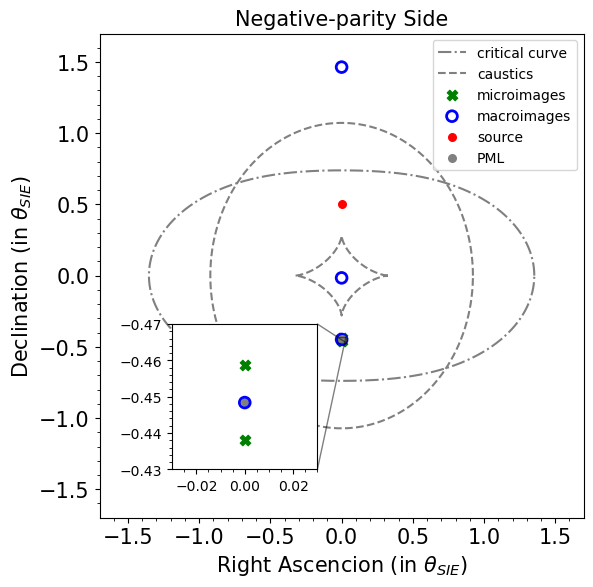

time: 491 ms (started: 2023-06-19 19:13:14 +08:00)


In [20]:
# Sky plot of the complete model
# PML at the most magnified macroimage on the positive side of the SIE

nr_10e6_PML_neg, nc_10e6_PML_neg = 1, 1

fig_10e6_PML_neg, axs_10e6_PML_neg = plt.subplots(nrows=nr_10e6_PML_neg, ncols=nc_10e6_PML_neg, sharey=True, sharex=True, figsize=(6,6))

axs_10e6_PML_neg.plot(theta_1, theta_2, color='grey', linewidth=1.5, label='critical curve', linestyle='dashdot')
axs_10e6_PML_neg.plot(beta_1_in, beta_2_in, color='grey', linewidth=1.5, label='caustics', linestyle='dashed')
axs_10e6_PML_neg.plot(beta_1_out, beta_2_out, color='grey', linewidth=1.5, linestyle='dashed')

axs_10e6_PML_neg.scatter(spp_micro_neg_ra, spp_micro_neg_dec, marker='X', label='microimages', 
                     s=60, linewidth=0.7, color='green')
axs_10e6_PML_neg.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='o', label='macroimages', 
                     s=60, linewidth=2, color='blue', facecolor='none')
axs_10e6_PML_neg.scatter(y0, y1, color='red', s=30, label='source')
axs_10e6_PML_neg.scatter(MacroImg_ra_10e6[1]/thetaE_SIE_10e6, MacroImg_dec_10e6[1]/thetaE_SIE_10e6, 
                     label='PML', color='gray', s=30)

# inset axes....
axins_10e6_PML_neg = axs_10e6_PML_neg.inset_axes([0.15, 0.1, 0.3, 0.3])
axins_10e6_PML_neg.scatter(Img_ra_10e6_PML_neg/thetaE, Img_dec_10e6_PML_neg/thetaE, marker='X', label='microimages', 
                 s=60, linewidth=0.7, color='green')
axins_10e6_PML_neg.scatter(MacroImg_ra_10e6[1]/thetaE_SIE_10e6, MacroImg_dec_10e6[1]/thetaE_SIE_10e6, 
                     label='PML', color='grey', s=30)
axins_10e6_PML_neg.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='o', label='macroimages', 
                     s=60, linewidth=2, color='blue', facecolor='none')

# sub region of the original image
xxx1, xxx2, yyy1, yyy2 = -0.03, 0.03, -0.43, -0.47
axins_10e6_PML_neg.set_xlim(xxx1, xxx2)
axins_10e6_PML_neg.set_ylim(yyy1, yyy2)
#axins_10e6_PML.set_xticklabels([])
#axins_10e6_PML.set_yticklabels([])
axins_10e6_PML_neg.minorticks_on()
axs_10e6_PML_neg.indicate_inset_zoom(axins_10e6_PML_neg, edgecolor="black")
axs_10e6_PML_neg.minorticks_on()


axs_10e6_PML_neg.set_title(r'Negative-parity Side')
axs_10e6_PML_neg.title.set_size(15)
#axs_10e6_PML_neg.set(xlabel=r'Right Ascencion (in $\theta_{SIE}$)', ylabel=r'Declination (in $\theta_{SIE}$)')
axs_10e6_PML_neg.set_xlabel(r'Right Ascencion (in $\theta_{SIE}$)', fontsize=15)
axs_10e6_PML_neg.set_ylabel(r'Declination (in $\theta_{SIE}$)', fontsize=15)
axs_10e6_PML_neg.label_outer()
axs_10e6_PML_neg.minorticks_on()
axs_10e6_PML_neg.set_xlim([-1.7,1.7])
axs_10e6_PML_neg.set_ylim([-1.7,1.7])
axs_10e6_PML_neg.set_aspect('equal', adjustable='box')
axs_10e6_PML_neg.legend(ncol=1, loc='upper right')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/micro_neg_parity', dpi=300)
plt.show()

## Lensed Gravitational Waves


In [21]:
# Lensed Gravitational waves by PML on the Positive Parity Side of the SIE

# This script illustrates how to use lensingGW's lensed waveform routines
import numpy as np

######################
# lens configuration #
######################

# source position, in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# redshifts
zL, zS = 0.5, 2.0

# binary point mass lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[0], 'center_y':MacroImg_dec_10e6[0], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# binary point mass images, in radians
ra_pos  = Img_ra_10e6_PML
dec_pos = Img_dec_10e6_PML

####################
# lensed waveforms #
####################

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the lensed waveform polarizations, strains in the requested detectors and their frequencies
freqs_lensed_pos, hp_tilde_lensed_pos, hc_tilde_lensed_pos, lensed_strain_dict_pos = waveform_model.lensed_gw(ra_pos,dec_pos,
                                                                                              beta0,beta1,
                                                                                              zL, zS,
                                                                                              lens_model_list,
                                                                                              kwargs_lens_list)

# and their signal-to-noise-ratios
lensed_SNR_dict_pos = waveform_model.lensed_snr(ra_pos,dec_pos,
                                            beta0,beta1,
                                            zL, zS,
                                            lens_model_list,
                                            kwargs_lens_list)

# access a lensed strain
lensed_sH1_pos = lensed_strain_dict_pos['H1']


---- Will simulate a signal with the following parameters ----

m1          --> 45
m2          --> 36
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 0
dec         --> 4.904407255147181e-09
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Lensed SNR in H1 = 8.25
Network SNR of the lensed simulation 8.250423

time: 25 ms 

In [22]:
# Lensed Gravitational waves by PML on the Negative Parity Side of the SIE

# This script illustrates how to use lensingGW's lensed waveform routines
import numpy as np

######################
# lens configuration #
######################

# source position, in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# redshifts
zL, zS = 0.5, 2.0

# binary point mass lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[0], 'center_y':MacroImg_dec_10e6[0], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# binary point mass images, in radians
ra_neg  = Img_ra_10e6_PML_neg
dec_neg = Img_dec_10e6_PML_neg

####################
# lensed waveforms #
####################

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the lensed waveform polarizations, strains in the requested detectors and their frequencies
freqs_lensed_neg, hp_tilde_lensed_neg, hc_tilde_lensed_neg, lensed_strain_dict_neg = waveform_model.lensed_gw(ra_neg,dec_neg,
                                                                                              beta0,beta1,
                                                                                              zL, zS,
                                                                                              lens_model_list,
                                                                                              kwargs_lens_list)

# and their signal-to-noise-ratios
lensed_SNR_dict_neg = waveform_model.lensed_snr(ra_neg,dec_neg,
                                            beta0,beta1,
                                            zL, zS,
                                            lens_model_list,
                                            kwargs_lens_list)

# access a lensed strain
lensed_sH1_neg = lensed_strain_dict_neg['H1']


---- Will simulate a signal with the following parameters ----

m1          --> 45
m2          --> 36
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 0
dec         --> 4.904407255147181e-09
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Lensed SNR in H1 = 3.17
Network SNR of the lensed simulation 3.167472

time: 38.2 m

## Plots

In [23]:
aLIGO_freq = []
aLIGO_strain = []

with open(r"/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat") as datFile:
    for data in datFile:
        aLIGO_freq.append(float(data.split()[0]))
        aLIGO_strain.append(float(data.split()[1]))

AdV_freq = []
AdV_strain = []

with open(r"/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-AdV_DESIGN_psd.dat") as datFile1:
    for data in datFile1:
        AdV_freq.append(float(data.split()[0]))
        AdV_strain.append(float(data.split()[1]))



time: 7.46 ms (started: 2023-06-19 19:13:14 +08:00)


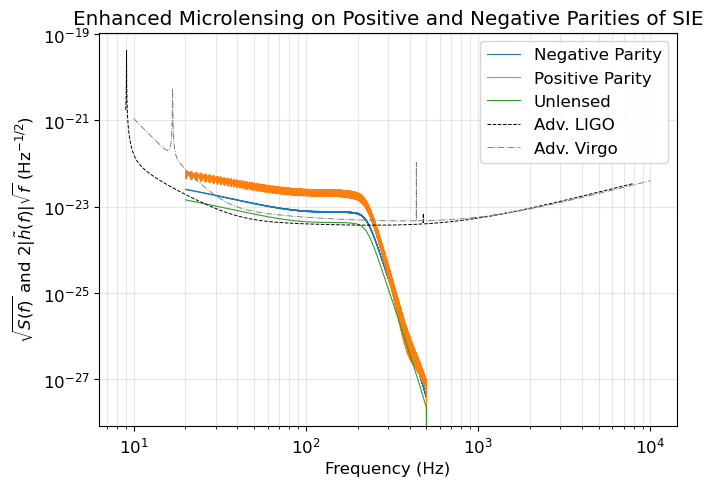

time: 525 ms (started: 2023-06-19 20:32:12 +08:00)


In [50]:
# Unlensed vs Positive Parity Lensed vs Negative Parity Lensed GWs

fig_GWs, axs_GWs = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

axs_GWs.plot(freqs_lensed_neg, (2*np.abs(lensed_sH1_neg))*(freqs_lensed_neg)**(1/2), label='Negative Parity', linewidth=0.8)
axs_GWs.plot(freqs_lensed_pos, (2*np.abs(lensed_sH1_pos))*(freqs_lensed_pos)**(1/2), label='Positive Parity', linewidth=0.8)
axs_GWs.plot(freqs, (2*np.abs(sH1))*(freqs)**(1/2), label='Unlensed', linewidth=0.8)

axs_GWs.plot(np.array(aLIGO_freq), (np.array(aLIGO_strain))**(1/2), label='Adv. LIGO', 
         linewidth=0.7, linestyle='--', color='black')
axs_GWs.plot(np.array(AdV_freq), (np.array(AdV_strain))**(1/2), label='Adv. Virgo', 
         linewidth=0.7, linestyle='-.', color='grey')

#axs_GWs.set_xlim([20, 300])
#axs_GWs.set_ylim([10e-25, 1.5*10e-23])
axs_GWs.set_xscale('log')
axs_GWs.set_yscale('log')
axs_GWs.minorticks_on()

axs_GWs.set_title(r'Enhanced Microlensing on Positive and Negative Parities of SIE')
axs_GWs.set(xlabel=r'Frequency (Hz)', ylabel=r'$\sqrt{S(f)}$ and $2|\tilde{h}(f)|\sqrt{f}$ (Hz$^{-1/2}$)')
axs_GWs.legend(ncol=1, loc='upper right')

plt.grid(True, which='both', alpha=0.3)
plt.legend(ncol=1, loc='upper right')
plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/EnhanceMicrolensing', dpi=300)
plt.show()

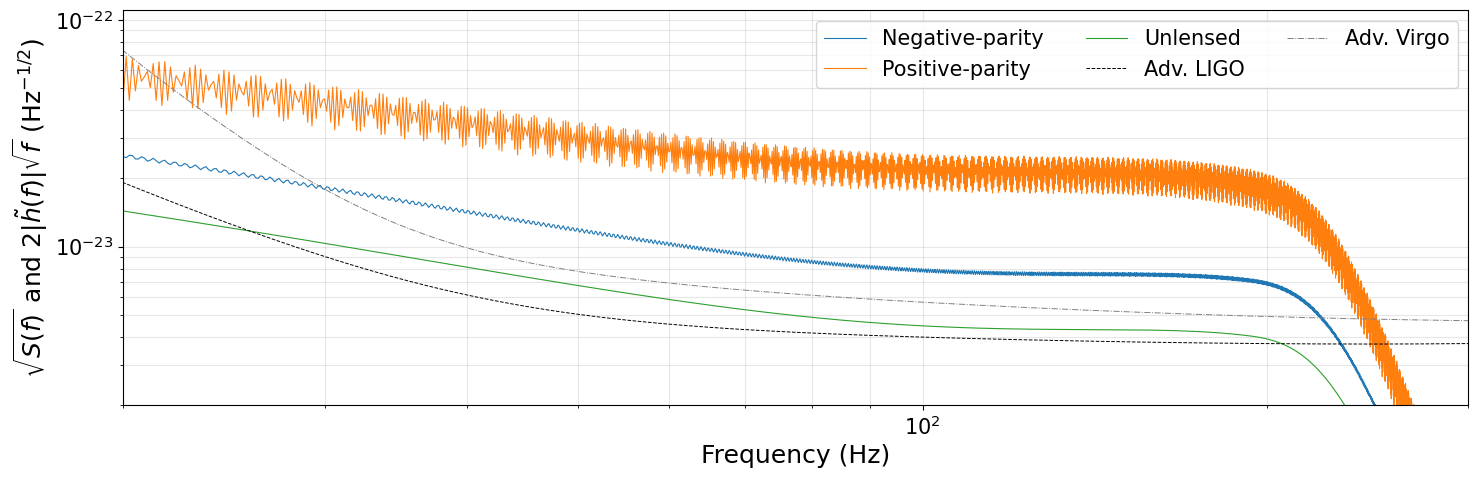

time: 673 ms (started: 2023-06-19 19:13:15 +08:00)


In [25]:
# combined plots for resulting macroimages and the enhanced microlensing

# Unlensed vs Positive Parity Lensed vs Negative Parity Lensed GWs

mpl.rcParams.update({'font.size': 15})

fig_GWs, axs_GWs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

axs_GWs.plot(freqs_lensed_neg, (2*np.abs(lensed_sH1_neg))*(freqs_lensed_neg)**(1/2), label='Negative-parity', linewidth=0.8)
axs_GWs.plot(freqs_lensed_pos, (2*np.abs(lensed_sH1_pos))*(freqs_lensed_pos)**(1/2), label='Positive-parity', linewidth=0.8)
axs_GWs.plot(freqs, (2*np.abs(sH1))*(freqs)**(1/2), label='Unlensed', linewidth=0.8)

axs_GWs.plot(np.array(aLIGO_freq), (np.array(aLIGO_strain))**(1/2), label='Adv. LIGO', 
         linewidth=0.7, linestyle='--', color='black')
axs_GWs.plot(np.array(AdV_freq), (np.array(AdV_strain))**(1/2), label='Adv. Virgo', 
         linewidth=0.7, linestyle='-.', color='grey')

axs_GWs.set_xlim([20, 300])
axs_GWs.set_ylim([2e-24, 1.1*10e-23])
axs_GWs.set_xscale('log')
axs_GWs.set_yscale('log')
axs_GWs.minorticks_on()

#axs_GWs.set_title(r'Enhanced Microlensing on Positive and Negative Parities of SIE')
#axs_GWs.set(xlabel=r'Frequency (Hz)', ylabel=r'$\sqrt{S(f)}$ and $2|\tilde{h}(f)|\sqrt{f}$ (Hz$^{-1/2}$)')
axs_GWs.set_xlabel(r'Frequency (Hz)', fontsize=18)
axs_GWs.set_ylabel(r'$\sqrt{S(f)}$ and $2|\tilde{h}(f)|\sqrt{f}$ (Hz$^{-1/2}$)', fontsize=18)
axs_GWs.legend(ncol=1, loc='upper right')

plt.grid(True, which='both', alpha=0.3)
plt.legend(ncol=3, loc='upper right', fontsize=15)
plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/EnhanceMicrolensing_spp2023', dpi=300)
plt.show()

In [53]:
# Comparison of Lensed Signals with Positive and negative parity signals
PosPar = (2*np.abs(lensed_sH1_pos))*(freqs_lensed_pos)**(1/2)
NegPar = (2*np.abs(lensed_sH1_neg))*(freqs_lensed_neg)**(1/2)
Unlensed = (2*np.abs(sH1))*(freqs)**(1/2)


# Ratios
n = 2500

PosPar_Unlensed = sum(np.nan_to_num(PosPar[:n]/Unlensed[:n]))/len(PosPar[:n])
print(PosPar_Unlensed)

NegPar_Unlensed = sum(np.nan_to_num(NegPar[:n]/Unlensed[:n]))/len(NegPar[:n])
print(NegPar_Unlensed)

4.143464196144995
1.7553362608735457
time: 13.4 ms (started: 2023-06-19 20:55:30 +08:00)


## Fringe Analysis

/var/folders/z7/s5rym2f96s37ltj5j14bx20w0000gn/T/ipykernel_76150/1941750272.py:5: RuntimeWarning: invalid value encountered in true_divide
  ratio_pos = lensed_sH1_pos/sH1


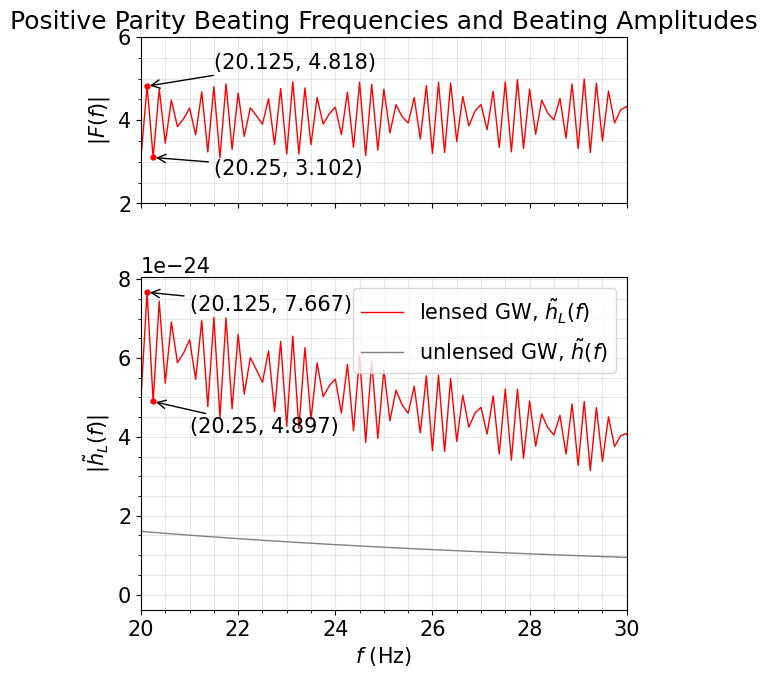

time: 616 ms (started: 2023-06-19 19:13:15 +08:00)


In [26]:
# Plot |F(omega)| vs frequency
# Estimate lens mass
# Using lensed GW from positive parity side

ratio_pos = lensed_sH1_pos/sH1
F_pos = np.abs(np.nan_to_num(ratio_pos))

fig_LensMass_pos, axs_LensMass_pos = plt.subplots(sharex=True, nrows=2, ncols=1, figsize=(6,7), gridspec_kw={'height_ratios': [1, 2]})

axs_LensMass_pos[0].plot(freqs, F_pos, color='red', linewidth=1)
axs_LensMass_pos[0].scatter(freqs[1:3], F_pos[1:3], color='red', marker='o', s=12)
axs_LensMass_pos[0].set_xlim([20,30])
axs_LensMass_pos[0].set_ylim([2, 6])
axs_LensMass_pos[0].minorticks_on()
axs_LensMass_pos[0].set(ylabel=r'$|F(f)|$')
#axs_LensMass_pos[0].set_xscale('log')
#axs_LensMass_pos[0].set_yscale('log')
axs_LensMass_pos[0].set_title(r'Positive Parity Beating Frequencies and Beating Amplitudes')
axs_LensMass_pos[0].grid(True, which='both', alpha=0.3)
axs_LensMass_pos[0].annotate('('+str(freqs[1])+', 4.818)', xy=(freqs[1], F_pos[1]), xytext=(21.5, 5.25),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
axs_LensMass_pos[0].annotate('('+str(freqs[2])+', 3.102)', xy=(freqs[2], F_pos[2]), xytext=(21.5, 2.7),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[0].text(20.4, 2.85, str((freqs[2], 3.102)), color='red')

axs_LensMass_pos[1].plot(freqs, np.abs(lensed_sH1_pos), color='red', linewidth=1, label=r'lensed GW, $\tilde{h}_L(f)$')
axs_LensMass_pos[1].plot(freqs, np.abs(sH1), color='gray', linewidth=1, label=r'unlensed GW, $\tilde{h}(f)$')
axs_LensMass_pos[1].scatter(freqs[1:3], np.abs(lensed_sH1_pos)[1:3], color='red', marker='o', s=12)
axs_LensMass_pos[1].set_xlim([20,30])
#axs_LensMass_pos[1].set_ylim([5e-25, 8e-24])
#axs_LensMass_pos[1].set_xscale('log')
#axs_LensMass_pos[1].set_yscale('log')
#axs_LensMass_pos[1].set_xticklabels(rotation=90)
axs_LensMass_pos[1].minorticks_on()
axs_LensMass_pos[1].set(xlabel=r'$f$ (Hz)', ylabel=r'$|\tilde{h}_L(f)|$')
#axs_LensMass_pos[1].annotate(20.2, 77e-25, , color='red')
#axs_LensMass_pos[1].text(20.4, 48e-25, str((freqs[2], 3.102)), color='red')
axs_LensMass_pos[1].annotate('('+str(freqs[1])+', 7.667)', xy=(freqs[1], np.abs(lensed_sH1_pos)[1]), xytext=(21, 7.2e-24),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
axs_LensMass_pos[1].annotate('('+str(freqs[2])+', 4.897)', xy=(freqs[2], np.abs(lensed_sH1_pos)[2]), xytext=(21, 4.1e-24),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/LensMass_pos', dpi=300)
plt.show()

In [27]:
lens_mass = (1.25*10**4)*(7.667/4.897)/(20.25-20.125)
print(lens_mass)
# 1 order of magnitude away from the actual lens mass used

156565.24402695528
time: 219 µs (started: 2023-06-19 19:13:16 +08:00)


/var/folders/z7/s5rym2f96s37ltj5j14bx20w0000gn/T/ipykernel_76150/2381690256.py:7: RuntimeWarning: invalid value encountered in true_divide
  ratio_pos = lensed_sH1_pos/sH1
/var/folders/z7/s5rym2f96s37ltj5j14bx20w0000gn/T/ipykernel_76150/2381690256.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio_neg = lensed_sH1_neg/sH1


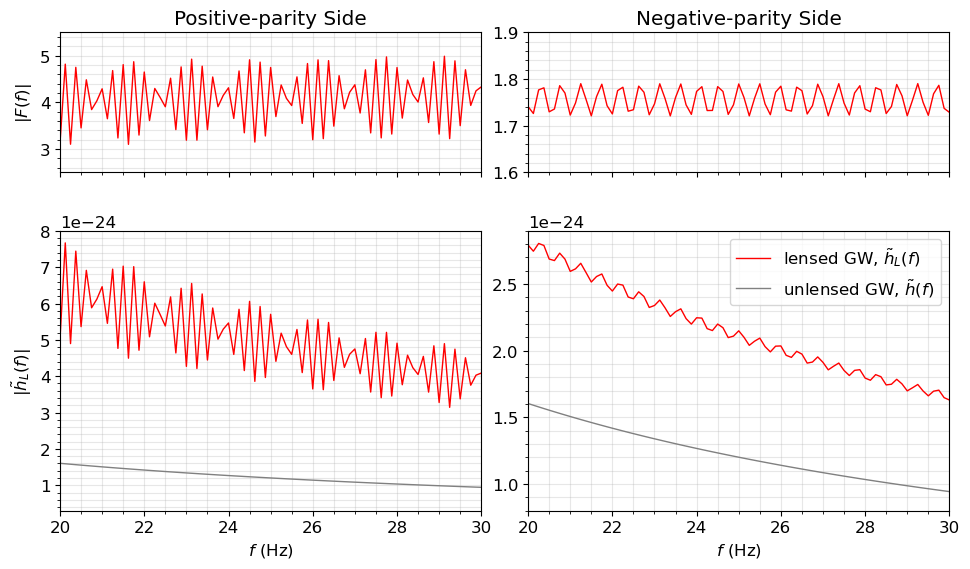

time: 699 ms (started: 2023-06-19 19:13:16 +08:00)


In [28]:
# Plot |F(omega)| vs frequency
# Estimate lens mass
# Using lensed GW from positive parity side

mpl.rcParams.update({'font.size': 12})

ratio_pos = lensed_sH1_pos/sH1
ratio_neg = lensed_sH1_neg/sH1
F_pos = np.abs(np.nan_to_num(ratio_pos))
F_neg = np.abs(np.nan_to_num(ratio_neg))

fig_LensMass_pos, axs_LensMass_pos = plt.subplots(sharex=True, nrows=2, ncols=2, figsize=(10,6), gridspec_kw={'height_ratios': [1, 2]})

axs_LensMass_pos[0,0].plot(freqs, F_pos, color='red', linewidth=1)
#axs_LensMass_pos[0].scatter(freqs[1:3], F_pos[1:3], color='red', marker='o', s=12)
axs_LensMass_pos[0,0].set_xlim([20,30])
axs_LensMass_pos[0,0].set_ylim([2.5, 5.5])
axs_LensMass_pos[0,0].minorticks_on()
axs_LensMass_pos[0,0].set(ylabel=r'$|F(f)|$')
#axs_LensMass_pos[0].set_xscale('log')
#axs_LensMass_pos[0].set_yscale('log')
axs_LensMass_pos[0,0].set_title(r'Positive-parity Side')
axs_LensMass_pos[0,0].grid(True, which='both', alpha=0.3)
#axs_LensMass_pos[0].annotate('('+str(freqs[1])+', 4.818)', xy=(freqs[1], F_pos[1]), xytext=(21.5, 5.25),
#                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[0].annotate('('+str(freqs[2])+', 3.102)', xy=(freqs[2], F_pos[2]), xytext=(21.5, 2.7),
#                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[0].text(20.4, 2.85, str((freqs[2], 3.102)), color='red')

axs_LensMass_pos[1,0].plot(freqs, np.abs(lensed_sH1_pos), color='red', linewidth=1, label=r'lensed GW, $\tilde{h}_L(f)$')
axs_LensMass_pos[1,0].plot(freqs, np.abs(sH1), color='gray', linewidth=1, label=r'unlensed GW, $\tilde{h}(f)$')
#axs_LensMass_pos[1].scatter(freqs[1:3], np.abs(lensed_sH1_pos)[1:3], color='red', marker='o', s=12)
axs_LensMass_pos[1,0].set_xlim([20,30])
axs_LensMass_pos[1,0].set_ylim([0.3e-24, 8e-24])
#axs_LensMass_pos[1].set_xscale('log')
#axs_LensMass_pos[1].set_yscale('log')
#axs_LensMass_pos[1].set_xticklabels(rotation=90)
axs_LensMass_pos[1,0].minorticks_on()
axs_LensMass_pos[1,0].set(xlabel=r'$f$ (Hz)', ylabel=r'$|\tilde{h}_L(f)|$')
axs_LensMass_pos[1,0].grid(True, which='both', alpha=0.3)
#axs_LensMass_pos[1].annotate(20.2, 77e-25, , color='red')
#axs_LensMass_pos[1].text(20.4, 48e-25, str((freqs[2], 3.102)), color='red')
#axs_LensMass_pos[1].annotate('('+str(freqs[1])+', 7.667)', xy=(freqs[1], np.abs(lensed_sH1_pos)[1]), xytext=(21, 7.2e-24),
                            #arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[1].annotate('('+str(freqs[2])+', 4.897)', xy=(freqs[2], np.abs(lensed_sH1_pos)[2]), xytext=(21, 4.1e-24),
                            #arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    
####

axs_LensMass_pos[0,1].plot(freqs, F_neg, color='red', linewidth=1)
#axs_LensMass_pos[0].scatter(freqs[1:3], F_pos[1:3], color='red', marker='o', s=12)
axs_LensMass_pos[0,1].set_xlim([20,30])
axs_LensMass_pos[0,1].set_ylim([1.6, 1.9])
axs_LensMass_pos[0,1].minorticks_on()
#axs_LensMass_pos[0,1].set(ylabel=r'$|F(f)|$')
#axs_LensMass_pos[0].set_xscale('log')
#axs_LensMass_pos[0].set_yscale('log')
axs_LensMass_pos[0,1].set_title(r'Negative-parity Side')
axs_LensMass_pos[0,1].grid(True, which='both', alpha=0.3)
#axs_LensMass_pos[0].annotate('('+str(freqs[1])+', 4.818)', xy=(freqs[1], F_pos[1]), xytext=(21.5, 5.25),
#                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[0].annotate('('+str(freqs[2])+', 3.102)', xy=(freqs[2], F_pos[2]), xytext=(21.5, 2.7),
#                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[0].text(20.4, 2.85, str((freqs[2], 3.102)), color='red')

axs_LensMass_pos[1,1].plot(freqs, np.abs(lensed_sH1_neg), color='red', linewidth=1, label=r'lensed GW, $\tilde{h}_L(f)$')
axs_LensMass_pos[1,1].plot(freqs, np.abs(sH1), color='gray', linewidth=1, label=r'unlensed GW, $\tilde{h}(f)$')
#axs_LensMass_pos[1].scatter(freqs[1:3], np.abs(lensed_sH1_pos)[1:3], color='red', marker='o', s=12)
axs_LensMass_pos[1,1].set_xlim([20,30])
axs_LensMass_pos[1,1].set_ylim([0.8e-24, 2.9e-24])
#axs_LensMass_pos[1].set_xscale('log')
#axs_LensMass_pos[1].set_yscale('log')
#axs_LensMass_pos[1].set_xticklabels(rotation=90)
axs_LensMass_pos[1,1].minorticks_on()
axs_LensMass_pos[1,1].set(xlabel=r'$f$ (Hz)')
#axs_LensMass_pos[1].annotate(20.2, 77e-25, , color='red')
#axs_LensMass_pos[1].text(20.4, 48e-25, str((freqs[2], 3.102)), color='red')
#axs_LensMass_pos[1].annotate('('+str(freqs[1])+', 7.667)', xy=(freqs[1], np.abs(lensed_sH1_pos)[1]), xytext=(21, 7.2e-24),
                            #arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[1].annotate('('+str(freqs[2])+', 4.897)', xy=(freqs[2], np.abs(lensed_sH1_pos)[2]), xytext=(21, 4.1e-24),
                            #arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.tight_layout(pad=1.5, w_pad=0, h_pad=2)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/LensMass_pos_neg', dpi=300)
plt.show()